# **Reddit Sentiment Analysis**

*Written by Adithya Solai*

## **Overview**

A script that fetches top Reddit posts from subreddits that match keywords, and then applies Sentiment Analysis on the comments section of each of those posts to calculate a Positivity & Negativity Score for each post. The keywords and subreddits to query are specified by the user.

The VADER Sentiment Analyzer framework (https://www.nltk.org/_modules/nltk/sentiment/vader.html) is used to fetch a compound positivity/negativity score for each word in each comment of each post. Various normalization procedures are applied on these compound scores to enable comparisons between posts. After normalizations, the positive compound scores in each post's comments are summed to create an overall Positivity score for the post, and the same is done with negative compound scores for an overall Negativity score. The Positivity & Negativity scores for each post are then visualized.

Body text of posts are not considered for this analysis because many popular Reddit posts are simply URL links to videos, which don't have any meaningful text to analyze. Only top-level comments are considered for analysis, which means replies to comments are not considered.

## **Pre-Requisite Packages & Datasets**

In [ ]:
pip install numpy \
&& pip install pandas \
&& pip install praw \
&& pip install nltk \
&& pip install emoji \
&& pip install en_core_web_sm \
&& pip install -U matplotlib==3.1.3

In [ ]:
import praw # PRAW API (https://praw.readthedocs.io/en/latest/index.html) is used to fetch comment data from Reddit.
import numpy as np
import pandas as pd
import nltk
import time
import pprint
pp = pprint.PrettyPrinter(indent=4)

# sentiment analysis libraries
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

# Data pre-processing steps were taken from this tutorial: https://levelup.gitconnected.com/reddit-sentiment-analysis-with-python-c13062b862f6
# data pre-processing libraries
from datetime import datetime
nltk.download('wordnet')
from nltk.tokenize import RegexpTokenizer # tokenizes comments into individual words
from nltk.stem import WordNetLemmatizer # lemmatizes words to capture only the root of each word
from nltk import FreqDist
import emoji # to remove emojis
import re # to remove links
import en_core_web_sm # to get stopwords

# visualization libraries
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **Load Reddit Sentiment Analysis Algorithm**

In [ ]:
'''
To use the Reddit PRAW API, you must first make a Reddit App.

Then, find your App at the bottom of this page: https://www.reddit.com/prefs/apps
Click "Edit" to find your client_id under the name of your App, and your App secret.

We also need a User Agent string that identifies our Web Browser type to 
send HTTPS requests to the Reddit API servers. This can easily be found here:
https://www.whatismybrowser.com/detect/what-is-my-user-agent
'''
APEXFUND_REDDIT_APP_ID='App ID Here'
APEXFUND_REDDIT_APP_SECRET='App Secret Here'
MY_USER_AGENT='Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/93.0.4577.63 Safari/537.36'

# initialize PRAW Reddit API client
# The client should be not be in an asynchronous environment. Our use case is an
# isolated script that runs. Asynchronous clients are best suited for integrating
# Reddit API functionality into a web application or bot (to automatically
# write Reddit Posts or do some other action under the authentication of
# an individual user, for example). Our use case is read-only.
# There is also a variation of the PRAW API that is meant only for aynchronous use cases: https://asyncpraw.readthedocs.io/en/stable/
r = praw.Reddit(client_id=APEXFUND_REDDIT_APP_ID, client_secret=APEXFUND_REDDIT_APP_SECRET, user_agent=MY_USER_AGENT, check_for_async=False)

In [ ]:
'''
# Fetch Top 30 Reddit posts for the given search query in the given subreddit.
# For each post, fetch its Post ID, the timestamp of its creation, and its URL.
# Organize the details of each post into its own dictionary, and store those
# dictionaries into a list. (The list should have 30 elements, and each element
# is a post's details arranged into a dictionary)
'''
NUM_POSTS_TO_FETCH_LIMIT=30
def fetch_posts(subreddit, query):
  subreddit_to_search = r.subreddit(subreddit)

  posts = []

  for post in subreddit_to_search.search(query=query, sort='top', time_filter='year', limit=NUM_POSTS_TO_FETCH_LIMIT):
    post_dict = {}
    post_dict['id'] = post.id
    post_dict['timestamp'] = datetime.utcfromtimestamp(post.created_utc).strftime('%Y-%m-%d %H:%M:%S')
    post_dict['url'] = post.url
    posts.append(post_dict)

  return posts

In [ ]:
'''
The input to this function is the output of fetch_posts() above --
a list of the details for all 30 posts, where each element is a
dictionary with the post's details.

This function extracts the comments of each post, and adds
those comments to each post's detail dictionary.
'''
def extract_post_comments(posts):
  for post in posts:
    post_id = post['id']
    post['comments'] = extract_comments(post_id)

  return posts

In [ ]:
'''
A function that extracts all top-layer comments for a given Reddit post ID,
and puts the text, upvotes, and award coin value of each comment
into a Pandas df.

This function facilitates the extract_post_comments() function above.

By default, this function will only fetch the default max amount of top-layer
comments returned by the PRAW API, which is about 400 comments.
If the `expand_top_layer` input is True, then more top-layer comments
will be fetched, but this takes more time so it is left False by default.

This function does not support expanding into the second layer of comments and
below (meaning replies to top-layer comments, and replies to those replies).
'''
def extract_comments(submission_id, expand_top_layer=False):
  post = r.submission(id=submission_id)

  # Retrieve PRAW CommentForest object for the comments section (https://praw.readthedocs.io/en/stable/code_overview/other/commentforest.html)
  # A CommentForest is a list of Comment and MoreComments objects.
  # Comment objects are individual comments. By default, a CommentForest object only has a maximum of about 400 Comment objects
  # MoreComments objects are a pointer to a list of more individual Comment objects (this saves RAM memory space when fetching CommentForest objects)
  comment_forest = post.comments

  # Extract only individual Comment objects from CommentForest
  comment_objects = [comment for comment in comment_forest.list() if isinstance(comment, praw.models.reddit.comment.Comment)]

  # Expand MoreComments objects to get more top-level comments
  # This will only expand MoreComments objects once. Expanding a MoreComments object
  # can yield more MoreComments objects in addition to individual Comment objects,
  # but we will not expand that new level of MoreComments objects.
  if expand_top_layer:
    # Extract MoreComments objects from CommentForest
    more_comments_objects = [comment for comment in comment_forest.list() if isinstance(comment, praw.models.reddit.more.MoreComments)]

    # Fetch new list of Comment & MoreComments objects from each existing MoreComments object.
    for idx, more_comments in enumerate(more_comments_objects):
      curr_comments = more_comments.comments()
      comment_objects += curr_comments

    # trim off new MoreComments objects, and only keep individual Comment objects
    comment_objects = [comment for comment in comment_objects if isinstance(comment, praw.models.reddit.comment.Comment)]

  # Extract text, upvotes, and total award coin value of comments into DataFrame
  comments_df = pd.DataFrame([(str(comment.body), 
                               comment.score,
                               len(comment.all_awardings),
                               sum([award['coin_price'] for award in comment.all_awardings])) for comment in comment_objects],
                             columns=['text', 'upvotes', 'num_awards', 'total_award_coin_value'])
  return comments_df

In [ ]:
'''
Find positivity and negativity scores for each post, and add that to each post's 
detail dictionary. Along the way, a df with each word's polarity scores from
the VADER Sentiment Analyzer for each post's comment section will also be
added to the post's detail dictionary.
'''
def find_pos_neg_scores(posts):
  # pre-process post comments and find global max_upvotes and max_coin_value
  # global max_upvotes and max_coin_value are needed to normalize positivity and
  # negativity scores across posts so that score comparisons between posts are valid.
  global_max_upvotes = 1
  global_max_coin_value = 1
  for post in posts:
    post_id = post['id']
    post_comments = post['comments']

    # expand each comment into rows for each word in the comment with pre-processing tasks applied
    post_cleaned_comments = pre_process_comment_by_comment(pd.DataFrame(post_comments))

    # fetch compound polarity score (positivity/negaitivity) for each word in the post
    post_polarity_scores_df = convert_cleaned_comments_to_polarity_df(post_cleaned_comments)

    # ensure upvotes and total award coin value within each post are >=1 to make calculations
    # of positivity and negativity scores easier. 
    # also retrieve each post's largest upvotes value and largest total award coin value
    post_polarity_scores_df, curr_max_upvotes, curr_max_coin_value = fix_and_get_upvotes_and_coin_value(post_polarity_scores_df)

    post['polarity_df'] = post_polarity_scores_df

    # update global max upvotes & coin_value for future normalization across all posts
    global_max_upvotes = max(global_max_upvotes, curr_max_upvotes)
    global_max_coin_value = max(global_max_coin_value, curr_max_coin_value)

  # calculate positivity and negativity score
  for post in posts:
    post_polarity_scores_df = post['polarity_df']

    # use global largest upvotes and total award coin value to find overall positivity & negativity scores for each post
    # that can be validly compared to the scores of other posts
    post_macro_positivity_score, post_macro_negativity_score = calculate_pos_and_neg_scores(post_polarity_scores_df, global_max_upvotes, global_max_coin_value)

    post['scores'] = [post_macro_positivity_score, post_macro_negativity_score]

  return posts

In [ ]:
'''
The input to this function is the Pandas df returned by extract_comments().
The input df contains the text, upvotes, and total award coin value for each
comment in a Reddit post.

This function returns a list that essentially expands each row in the 
input df into more rows based on how many words were in the `text` column for the input df.

For example, if the input df has a row with "I love GameStop" in the `text` column,
that one row would be replaced by 3 new dictionaries in the output 2D-list: one dictionary
for each word in the sentence. Each new dictionary will also have the identifying ID, upvotes, 
and total award coin value of the original comment.

Each word in the output list will also have other data pre-processing procedures applied,
like removing emojis & URLs, as well as lemmatizing the word to only capture the root word.

If a row in the input df has words in the `text` column that are stopwords (words
that don't add meaningful sentiment to a sentence--like "and" & "the"), then those
words will not have a dictionary in the output list.
'''

def pre_process_comment_by_comment(comments_df):
  # Re-name left-most column to "comment_num" so that the output 2D-list's words
  # can be mapped to their original comment with this number
  comments_df['comment_num'] = comments_df.index

  # drop rows with any null values
  comments_df.dropna()

  # `text` column dtype still shows up as `object` instead of `str` because strings
  # can have variable length, so Pandas stores them as pointers to ndarrays of characters
  # (explained better here: https://stackoverflow.com/questions/21018654/strings-in-a-dataframe-but-dtype-is-object)
  comments_df = comments_df.astype({'text' : 'str'})

  ## Apply data cleaning procedures to each comment (removing emojis, stopwords, and URLs, & lemmatizing) ##
  
  # Put each comment's text into a str list to make pre-processing easier,
  # but keep upvotes, total award coin value, and comment_num attached to each word always.
  comments_df_as_list = comments_df.loc[:, ['comment_num', 'text', 'upvotes', 'total_award_coin_value']].values.tolist()

  # prepare output list
  cleaned_words = []

  # prepare tokenizer
  tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|http\S+')

  # fetch stopwords
  nlp = en_core_web_sm.load()
  all_stopwords = nlp.Defaults.stop_words # this is a set, so it is O(1) to check if a word is a stopword

  # prepare lemmatizer
  lemmatizer = WordNetLemmatizer()

  # apply text pre-processing on each comment
  for row in comments_df_as_list:
    comment_num = row[0]
    words = row[1]
    upvotes = row[2]
    coin_value = row[3]

    # remove emojis from comment text
    words = emoji.get_emoji_regexp().sub(u'', words)

    # tokenize comment text
    words = tokenizer.tokenize(words)

    # comment-level pre-processing tasks are done (like removing emojis and tokenizing)
    # now, apply word-level pre-processing and append to output list
    for word in words:
      # convert word to lower-case first
      word = word.lower()

      # only add to output list if word is not a stopword
      if word not in all_stopwords:
        # lemmatize word before adding to output 2D list
        word = lemmatizer.lemmatize(word)
        cleaned_words.append({"word": word, "comment_num": comment_num, "upvotes": upvotes, "coin_value": coin_value})

  return cleaned_words

In [ ]:
'''
The input to this function is the output of the pre_process_comment_by_comment()
function above--a list of dictionaries where each dictionary corresponds to a
word in a post, and the word's comment's upvotes and total award coin value are
also stored in the dictionary.

This function uses the VADER Sentiment Analyzer to fetch a compound
polarity score for each word in the input list. 

Compound polarity scores are between -1 (most negative) and +1 (most positive).
If the compound polarity score is:
- positive: then the word has positive sentiment 
- negative: then the word has negative sentiment
- zero: then the word has neutral sentiment
'''
def convert_cleaned_comments_to_polarity_df(clean_comments_data):
  #### Apply VADER Sentiment Analyzer to words from cleaned comments ####
  sia = SIA()
  results=[]

  for word_dict in clean_comments_data:
    word = word_dict['word']
    comment_num = word_dict['comment_num']
    upvotes = word_dict['upvotes']
    coin_value = word_dict['coin_value']
    
    # fetch polarity score for the current word
    # `pol_score` is already a key-value store dictionary with
    # the compound polarity score and other unused sentiment scores
    pol_score = sia.polarity_scores(word)

    # append new key-value entries to label these polarity scores
    # as belonging to the current word
    pol_score['word'] = word
    pol_score['comment_num'] = comment_num
    pol_score['upvotes'] = upvotes
    pol_score['coin_value'] = coin_value

    results.append(pol_score)

  # convert the list of dictionaries with word + polarity score info into a df
  polarity_scores_df = pd.DataFrame.from_records(results)

  return polarity_scores_df

In [ ]:
'''
The input to this function is the output df of the convert_cleaned_comments_to_polarity_df()
function above.

This function modifies the upvotes values and total award coin value of each comment
in this post so that they are all >= 1. Negative upvotes are possible for comments on Reddit,
so this is necessary. Also, allowing upvotes or total award coin value to be 0 can
cause issues with calculating normalized positivity & negativity scores later.

This function returns the modified df, as well as the largest upvotes value
and largest total award coin value for this post so that a global max
can be calculated for these values across all posts for further normalization.
'''
def fix_and_get_upvotes_and_coin_value(polarity_scores_df):
  # add all upvotes values by the min upvote value to make sure all upvotes are >= 0
  polarity_scores_df['upvotes'] = polarity_scores_df['upvotes'] + abs(polarity_scores_df['upvotes'].min())

  # add 1 to all upvotes to ensure all upvotes are >= 1 to avoid losing positivity/negativity
  # on words that have 0 upvotes when these upvote values are multiplied with compound polarity
  # scores to weight comments based on their relative upvotes
  polarity_scores_df['upvotes'] = polarity_scores_df['upvotes'] + 1
  # Do the same with award coin_value for the same reasons (we will also multiply compound polarity
  # scores with total award coin value for further weighting)
  polarity_scores_df['coin_value'] = polarity_scores_df['coin_value'] + 1

  # fetch max upvotes
  max_upvotes = polarity_scores_df['upvotes'].max()

  # fetch max coin_value
  max_coin_value = polarity_scores_df['coin_value'].max()

  return polarity_scores_df, max_upvotes, max_coin_value

In [ ]:
'''
The `polarity_scores_df` input df to this function is the same as the output df of the
fix_and_get_upvotes_and_coin_value() function above.

In this function, the upvotes and total award coin value for each comment are first
normalized (or divided) by the global maximum upvotes & total award coin value across 
all posts in this analysis. Then, the compound polarity scores for each word are weighted 
(or multiplied) by the new normalized upvotes and total award coin value. These two weighted
compound polarity scores (one weighted by upvotes, one weighted by total award coin value)
are summed to yield the "Macro-Normalized Compound Polarity Score" (or MNCPS) for each word.

To calculate positivity score for this post, we simply sum all the positive MNCPS.
To calculate negativity score for this post, we simply sum all the negative MNCPS.
'''
def calculate_pos_and_neg_scores(polarity_scores_df, global_max_upvotes, global_max_coin_value):
  # create compound score that works across many posts. only multiply by upvotes & award coin value for now.
  # then, we divide positivity/negativity scores by max upvotes & coin value across ALL posts
  polarity_scores_df['compound_macro'] = polarity_scores_df['compound'] * polarity_scores_df['upvotes'] / global_max_upvotes
  polarity_scores_df['compound_macro'] += polarity_scores_df['compound'] * polarity_scores_df['coin_value'] / global_max_coin_value

  #### Calculate and return macro positivity & negativity scores ####
  positivity_score_macro = polarity_scores_df.loc[polarity_scores_df['compound_macro'] > 0]['compound_macro'].sum()
  negativity_score_macro = polarity_scores_df.loc[polarity_scores_df['compound_macro'] < 0]['compound_macro'].sum()

  return (positivity_score_macro, negativity_score_macro)

In [ ]:
'''
This function uses the detail dictionary of each post to construct
a double bar plot of each post's positivity and negativity score.
The y-axis is the same units as the positivity and negativity scores,
and the x-axis is the time at which the post was created.

The original subreddit and keyword query are also taken as input 
for the title of the double bar plot.
'''
def plot_pos_neg_scores(posts, subreddit, query):
  bar_chart_data = []
  timestamps = []
  positivity_scores = []
  negativity_scores = []

  url_data = []

  for post in posts:
    post_timestamp = post['timestamp']
    post_scores = post['scores']
    post_url = post['url']

    # Use only date for cleaner graph
    post_timestamp_as_date = int(datetime.strptime(post_timestamp, '%Y-%m-%d %H:%M:%S').month)

    # Use abs() of negativity score to make bar chart cleaner
    post_positivity_score = post_scores[0]
    post_negativity_score = abs(post_scores[1])

    bar_chart_data.append([post_timestamp_as_date, post_positivity_score, post_negativity_score])
    url_data.append([post_timestamp_as_date, post_url])

  bar_chart_data = np.array(bar_chart_data)

  # sort by timestamp
  bar_chart_data = bar_chart_data[bar_chart_data[:, 0].argsort()]

  # Follow this documentation to make grouped bar chart:
  # https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html

  timestamps = bar_chart_data[:,0].astype('int')
  positivity_scores = bar_chart_data[:,1]
  negativity_scores = bar_chart_data[:,2]

  # position timestamp as x-coordinate
  x = np.arange(len(timestamps))  
  width = 0.3  # the width of the bars

  fig = plt.figure(figsize=(30,5))
  ax = fig.add_subplot(121)

  rects1 = ax.bar(x - width/2, positivity_scores, width, label='Positivity')
  rects2 = ax.bar(x + width/2, negativity_scores, width, label='Negativity')

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('Scores')
  ax.set_xlabel('Month in 2021')
  ax.set_title('Positivity & Negativity Scores for "{0}" Posts in r/{1} Over the Past Year'.format(query, subreddit))
  ax.set_xticks(x)
  ax.set_xticklabels(timestamps)
  ax.legend()

  plt.show()

  # Print URLs for each post in chronological order
  print("Post URLs in Same Chronological Order as Chart Above:")
  url_data = pd.DataFrame(url_data, columns = ['Month', 'URL'])
  url_data = url_data.sort_values('Month') # sort by timestamp

  for index, row in url_data.iterrows():
    print("Month: ", row['Month'], "URL: ", row['URL'])


## **Run Sentiment Analysis**

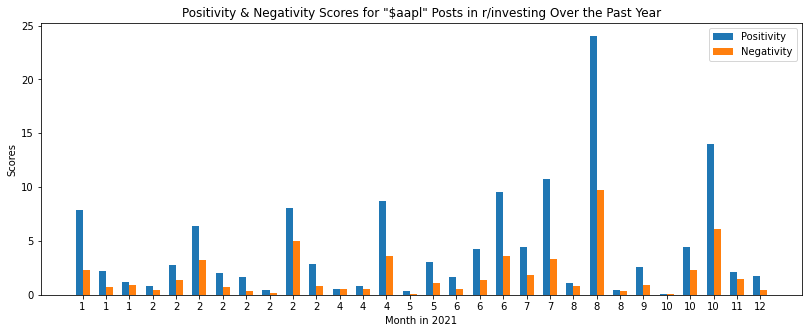

Post URLs in Same Chronological Order as Chart Above:
Month:  1 URL:  https://www.reddit.com/r/investing/comments/l3z5jq/i_created_an_algo_that_tracks_the_most_hyped/
Month:  1 URL:  https://www.reddit.com/r/investing/comments/l7jppw/what_stocks_are_you_looking_to_grab_at_a_possible/
Month:  1 URL:  https://www.reddit.com/r/investing/comments/l6eyjw/apple_reports_blowout_quarter_booking_more_than/
Month:  2 URL:  https://www.reddit.com/r/investing/comments/lrgpra/from_investorscom_6_top_warren_buffett_stocks/
Month:  2 URL:  https://www.reddit.com/r/investing/comments/lhwg4r/surge_by_disney_to_nearly_95_million/
Month:  2 URL:  https://www.reddit.com/r/investing/comments/lqqoks/watch_your_ps_ratio_ps_over_30_is_incredibly_risky/
Month:  2 URL:  https://www.reddit.com/r/investing/comments/lg297f/second_quarter_results_6_months_into_the/
Month:  2 URL:  https://www.reddit.com/r/investing/comments/ljpowg/analysing_institutional_investor_transactions/
Month:  2 URL:  https://www.reddit.com

In [ ]:
# Search Query can be modified with tools described here:
# https://www.reddit.com/wiki/search
subreddit = 'investing'
query = "$aapl"

start_time = time.time()
posts = fetch_posts(subreddit, query)
posts_with_extracted_comments = extract_post_comments(posts)
posts_with_pos_neg_scores = find_pos_neg_scores(posts_with_extracted_comments)
plot_pos_neg_scores(posts_with_pos_neg_scores, subreddit, query)
print("--- %s seconds ---" % (time.time() - start_time))